# Segmentation

In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import SimpleITK as sitk
import copy
import pydicom
from pydicom import dcmread
from pydicom.data import get_testdata_file
import gdcm
import os # for directory operations

import scipy
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from glob import glob
from skimage.util import montage as montage2d
from math import ceil
from ipywidgets.widgets import *  # ipywidgets for some interactive plots
import ipywidgets as widgets
from skimage import measure, morphology, segmentation
# from downloaddata import fetch_data as fdata
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# data
data_file = '/Volumes/My Passport for Mac/sample_images/'
patients = os.listdir(data_file)
labels_file = pd.read_csv('/Users/chutingyan/Downloads/MIDRC-RICORD-1a Clinical Data Jan 13 2021.csv', index_col=0)
patients.sort()
#print the first five rows
labels_file.head()

,Anon Age,AnonTCIA Study Date,Anon Exam Description,Anon Sex,Anon Study UID,Anon Image Count,Modality,Result,Specimen Source
Anon MRN,,,,,,,,,
419639-000082,84.84,8/2/02,CT CHEST WITHOUT CONTRAST,F,1.2.826.0.1.3680043.10.474.419639.312580455409...,1226,CT,1,Pooled NP/OP Swab
419639-000361,50.61,10/21/02,CT CHEST WITHOUT CONTRAST,F,1.2.826.0.1.3680043.10.474.419639.426473907903...,1139,CT,1,Nasopharyngeal Swab
419639-000421,63.41,12/5/06,CT CHEST WITHOUT CONTRAST,M,1.2.826.0.1.3680043.10.474.419639.308001698749...,965,CT,1,Nasopharyngeal Swab
419639-000582,63.93,12/6/02,CT CHEST WITH CONTRAST,M,1.2.826.0.1.3680043.10.474.419639.317104088349...,1141,CT,1,Pooled NP/OP Swab
419639-000800,48.25,5/11/05,CT CHEST WITHOUT CONTRAST,F,1.2.826.0.1.3680043.10.474.419639.119157449661...,1079,CT,1,NaN


In [ ]:
print (os.listdir(data_file))


In [ ]:
labels_file.Result.to_string(index=False)

# Load files

In [2]:
# Load the scans in given folder path
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
       
    return slices


In [3]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)


In [4]:
first_patient = load_scan(data_file + patients[1])
print(len(first_patient))

255


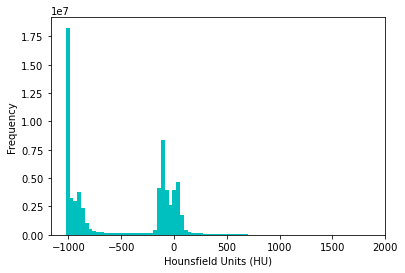

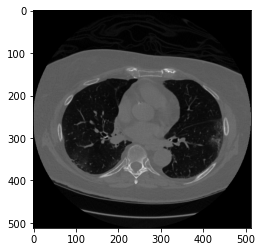

In [12]:
# first patient
first_patient = load_scan(data_file + patients[1])

first_patient_pixels = get_pixels_hu(first_patient)

plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.savefig("HU.png")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[125], cmap=plt.cm.gray)
plt.savefig("originalSlice1.png")
plt.show()

In [6]:
# slide through dicom images using a slide bar 
plt.figure(1)
def dicom_animation(x):
    plt.imshow(first_patient_pixels[x])
    return x
interact(dicom_animation, x=(0, len(first_patient_pixels)-1))

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=127, description='x', max=254), Output()), _dom_classes=('widget-interac…

<function __main__.dicom_animation(x)>

# Use simpleITK to view data

In [7]:
def safe_sitk_read(folder_name, *args, **kwargs):
    """
    Since the default function just looks at images 0 and 1 to determine slice thickness
    and the images are often not correctly alphabetically sorted
    :param folder_name: folder to read
    :return:
    """
    dicom_names = sitk.ImageSeriesReader().GetGDCMSeriesFileNames(folder_name)
    return sitk.ReadImage(dicom_names, *args, **kwargs)
def sitk_to_np(in_img):
    # type: (sitk.Image) -> Tuple[np.ndarray, Tuple[float, float, float]]
    return sitk.GetArrayFromImage(in_img), in_img.GetSpacing()

In [8]:
first_pat = safe_sitk_read(data_file + patients[1])
pat_img, pat_spc = sitk_to_np(first_pat)

In [9]:
pat_spc

(0.703125, 0.703125, 1.25)

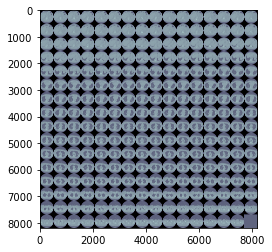

In [10]:
%matplotlib inline
plt.savefig("allSlices.png")
plt.imshow(montage2d(pat_img), cmap = 'bone')

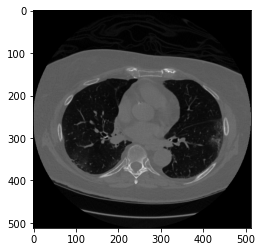

In [11]:
plt.savefig("originalSlice2.png")
plt.imshow(first_patient_pixels[125], cmap=plt.cm.gray)

# Threshold based segmentation

In [34]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
def segment_lung_mask(image, fill_lung_structures=True):
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image >= -700, dtype=np.int8)+1
    labels = measure.label(binary_image)
 
    # Pick the pixel in the very corner to determine which label is air.
    # Improvement: Pick multiple background labels from around the patient
    # More resistant to “trays” on which the patient lays cutting the air around the person in half
    background_label = labels[0,0,0]
 
    # Fill the air around the person
    binary_image[background_label == labels] = 2
 
    # Method of filling the lung structures (that is superior to 
    # something like morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
 
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
 
    # Remove other air pockets inside body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

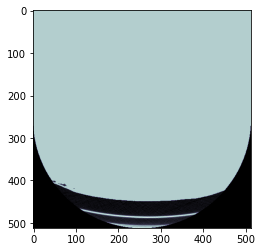

In [44]:
# get masks 
segmented_lungs = segment_lung_mask(first_patient_pixels,    
                  fill_lung_structures=False)
segmented_lungs_fill = segment_lung_mask(first_patient_pixels,     
                       fill_lung_structures=True)
internal_structures = segmented_lungs_fill - segmented_lungs
# isolate lung from chest
copied_pixels = copy.deepcopy(first_patient_pixels)
for i, mask in enumerate(segmented_lungs_fill): 
    get_high_vals = mask == 0
    copied_pixels[i][get_high_vals] = 0
seg_lung_pixels = copied_pixels
# sanity check
plt.savefig("testImage.png")
plt.imshow(seg_lung_pixels[225], cmap=plt.cm.bone) #not sucessfully show it

# Resamplying

In [8]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness, scan[0].PixelSpacing[0], scan[0].PixelSpacing[1]], dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [9]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (255, 512, 512)
Shape after resampling	 (319, 360, 360)


# 3D plotting the scan

In [10]:
#testing and learning, code from Guido Zuidhof
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, x, y = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.savefig("3dbone.png")
    plt.show()

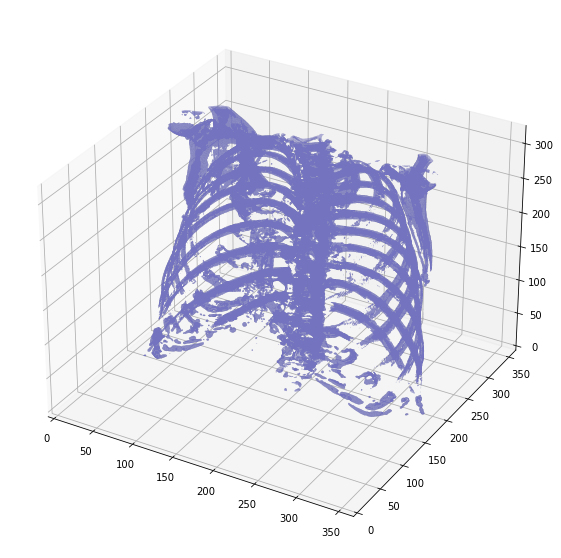

In [11]:
plot_3d(pix_resampled, 400)


# Threshold Segmentation

In [12]:
# testing and learning, code from Guido Zuidhof
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [13]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

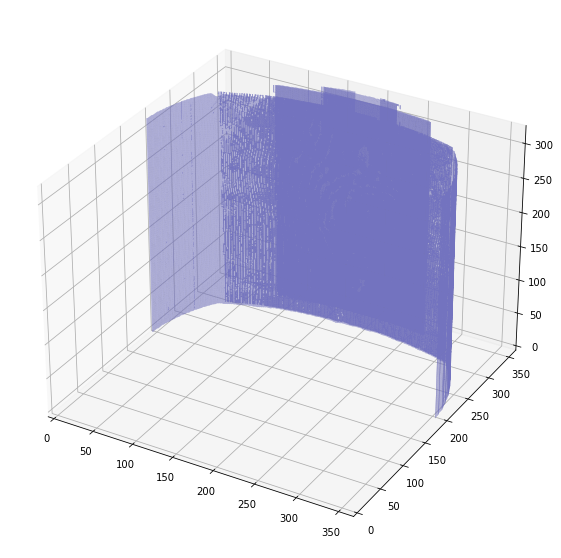

In [18]:
plot_3d(segmented_lungs, 0) # not successfully 

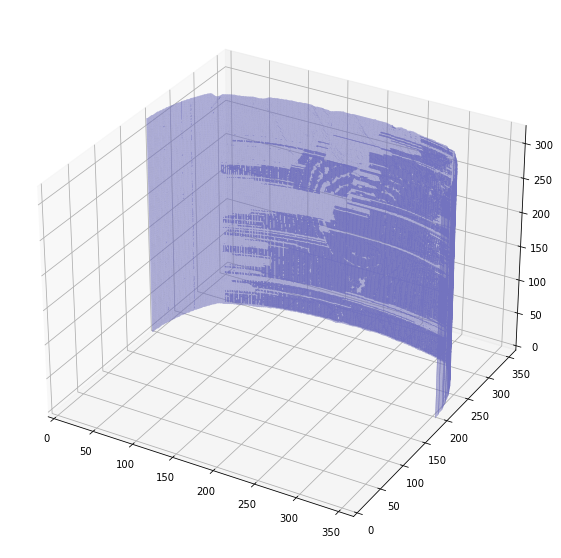

In [19]:
plot_3d(segmented_lungs_fill, 0) # not successfully 

# Processing data

In [21]:
for patient in patients[1:2]:
    #if not patient.startswith('.'):
        
    
    label = labels_file.Result.to_string(index=patient)
    path = data_file + patient
    slices = [pydicom.read_file(path + '/'+ s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    print(len(slices))
    print(slices[0])
   

    

257
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 208
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10.474.419639.272848588482897603497706095803
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance

In [41]:
for patient in patients[1:6]:
    label = labels_file.Result.to_string(index=patient)
    path = data_file + patient
    
    # a couple great 1-liners from: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
    slices = [dcmread(path + '/'+ s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    print(slices[0].pixel_array.shape, len(slices)) 
   

(512, 512) 255
(512, 512) 231
(512, 512) 284
(512, 512) 243
(512, 512) 203


In [28]:
len(patients)

13

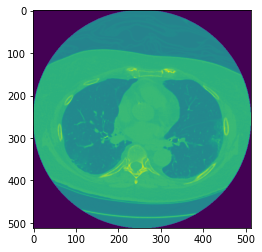

In [65]:
import matplotlib.pyplot as plt

for patient in patients[1:2]:
    label = labels_file.Result.to_string(index=patient)
    path = data_file + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    # the first slice
    plt.imshow(slices[125].pixel_array)
    plt.savefig("testSlice.png")
    plt.show()

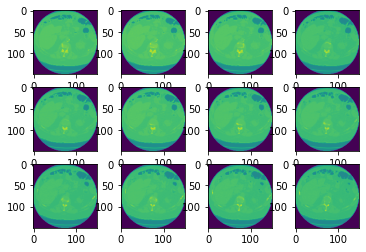

In [66]:
import cv2
import numpy as np

IMG_PX_SIZE = 150

for patient in patients[1:2]:
    label = labels_file.Result.to_string(index=patient)
    path = data_file + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    fig = plt.figure()
    for num,each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3,4,num+1)
        new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_img)
    plt.savefig("newSlice.png")
    plt.show()

In order to use marker based watershed segmentation, we need to identify two markers. An internal marker, that is definitely lung tissue and an external marker, that is definitely outside of our ROI. We're starting by creating the internal marker by thresholding the Image and removing all regions but the biggest one. The external marker is created by morphological dilation of the internal marker with 2 different iterations and subtracting the results. A watershed marker is created superimposing the 2 markers with different grayscale values.

# WaterShed Segmentation

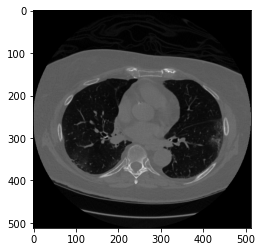

In [34]:
plt.savefig("watershedOriginal_1.png")
plt.imshow(first_patient_pixels[125], cmap=plt.cm.gray)

<ipython-input-14-ec1bfdaa71e5>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  marker_watershed = np.zeros((512, 512), dtype=np.int)


Internal Marker


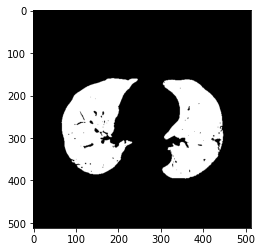

External Marker


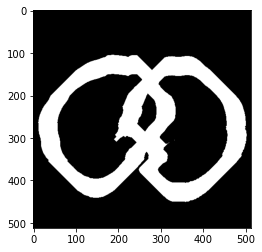

Watershed Marker


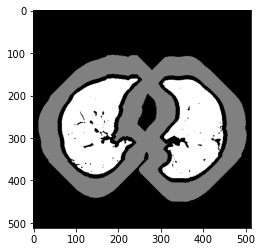

In [14]:
# Some of the starting Code is taken from ArnavJain, since it's more readable then my own
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

#Show some example markers from the middle        
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(first_patient_pixels[125])
print ("Internal Marker")
plt.savefig("internal_1.png")
plt.imshow(test_patient_internal, cmap='gray')
plt.savefig("external_1.png")
plt.show()
print ("External Marker")
plt.imshow(test_patient_external, cmap='gray')
plt.savefig("watershed_1.png")
plt.show()
print ("Watershed Marker")
plt.imshow(test_patient_watershed, cmap='gray')
plt.show()

Now we apply the marker based Watershed algorithm to find the precise border of the Lung located in the Black strip of the Watershed marker shown above. In order to do the algorithm we also need the Sobel-Gradient-Image of our original scan, which is calculated first.

In order to not miss nodules located next to the border regions a Black Top Hat Operation is performed to re-include those areas and areas surrounding the lung-hili. This is the main advantage of this method here over the methods from other kernels: Only areas that need re-inclusion get dilated, everywhere else the lung border stays precise.

In [16]:
def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1) # horizontal derivative
    sobel_filtered_dy = ndimage.sobel(image, 0) # vertical derivative
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy) # magnitude
    sobel_gradient *= 255.0 / np.max(sobel_gradient) # normalize 
    
    #Watershed algorithm
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))
    
    return segmented, lungfilter, outline, watershed, sobel_gradient, marker_internal, marker_external, marker_watershed

<ipython-input-14-ec1bfdaa71e5>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  marker_watershed = np.zeros((512, 512), dtype=np.int)
/Users/chutingyan/opt/anaconda3/envs/sitkpy/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Sobel Gradient


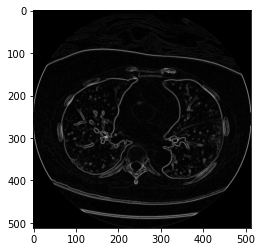

Watershed Image


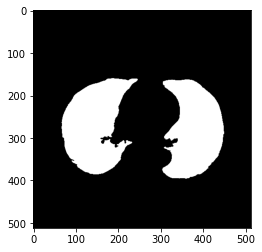

Outline after reinclusion


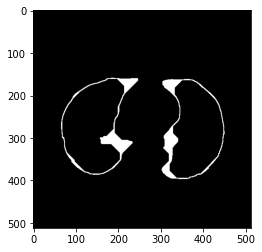

Lungfilter after closing


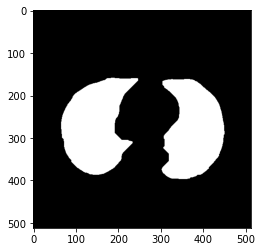

Segmented Lung


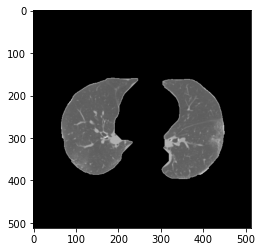

In [17]:
#Some Testcode:
test_segmented, test_lungfilter, test_outline, test_watershed, test_sobel_gradient, test_marker_internal, test_marker_external, test_marker_watershed = seperate_lungs(first_patient_pixels[125])

print ("Sobel Gradient")
plt.savefig("sobel_1.png")
plt.imshow(test_sobel_gradient, cmap='gray')
plt.show()
print ("Watershed Image")
plt.savefig("watershedAlgo_1.png")
plt.imshow(test_watershed, cmap='gray')
plt.show()
print ("Outline after reinclusion")
plt.savefig("outline_1.png")
plt.imshow(test_outline, cmap='gray')
plt.show()
print ("Lungfilter after closing")
plt.savefig("lungfilter_1.png")
plt.imshow(test_lungfilter, cmap='gray')
plt.show()
print ("Segmented Lung")
plt.savefig("segmented_1.png")
plt.imshow(test_segmented, cmap='gray')
plt.show()

# Test Watershed on another Image

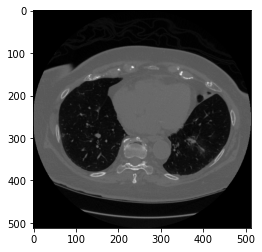

In [42]:
plt.savefig("watershedOriginal_2.png")
plt.imshow(first_patient_pixels[95], cmap=plt.cm.gray)

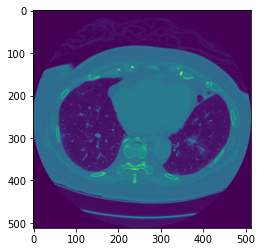

In [44]:
img = first_patient_pixels[95]
plt.imshow(img)

Internal Marker


<ipython-input-106-24102a395255>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  marker_watershed = np.zeros((512, 512), dtype=np.int)


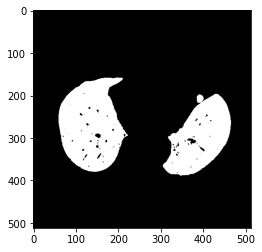

External Marker


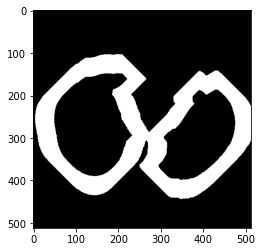

Watershed Marker


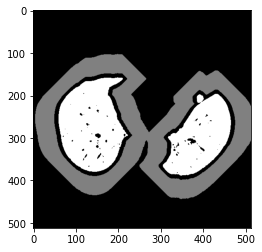

In [110]:
#Show some different examples        
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(first_patient_pixels[95])
print ("Internal Marker")
plt.savefig("internal_2.png")
plt.imshow(test_patient_internal, cmap='gray')
plt.show()
print ("External Marker")
plt.savefig("external_2.png")
plt.imshow(test_patient_external, cmap='gray')
plt.show()
print ("Watershed Marker")
plt.savefig("watershed_2.png")
plt.imshow(test_patient_watershed, cmap='gray')
plt.show()

<ipython-input-106-24102a395255>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  marker_watershed = np.zeros((512, 512), dtype=np.int)
/Users/chutingyan/opt/anaconda3/envs/sitkpy/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Sobel Gradient


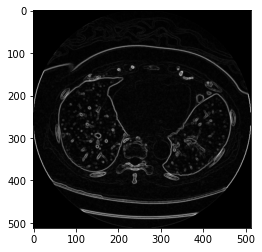

Watershed Image


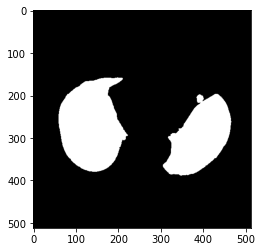

Outline after reinclusion


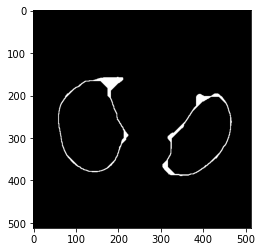

Lungfilter after closing


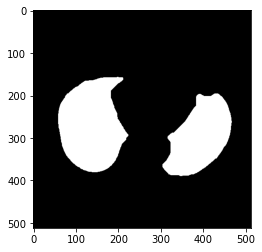

Segmented Lung


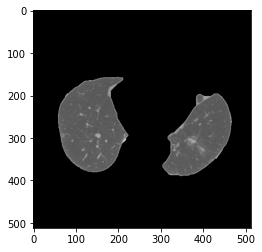

In [111]:
#Some Testcode:
test_segmented, test_lungfilter, test_outline, test_watershed, test_sobel_gradient, test_marker_internal, test_marker_external, test_marker_watershed = seperate_lungs(first_patient_pixels[95])

print ("Sobel Gradient")
plt.savefig("sobel_2.png")
plt.imshow(test_sobel_gradient, cmap='gray')
plt.show()
print ("Watershed Image")
plt.savefig("watershedAlgo_2.png")
plt.imshow(test_watershed, cmap='gray')
plt.show()
print ("Outline after reinclusion")
plt.savefig("outline_2.png")
plt.imshow(test_outline, cmap='gray')
plt.show()
print ("Lungfilter after closing")
plt.savefig("lungfilter_2.png")
plt.imshow(test_lungfilter, cmap='gray')
plt.show()
print ("Segmented Lung")
plt.savefig("segmented_2.png")
plt.imshow(test_segmented, cmap='gray')
plt.show()

## References are in individual report. 